## Package imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

----
## Display settings

In [2]:
pd.set_option("display.width", 140)

----
## Reading in the data

In [3]:
dtypes = {
    "MORTGAGE": "category",
    "MORTGAGE_GETTING_AGE": "Int64",
    "AGE": "int64",
    "YEARS_WITH_BANK": "int64",
    "MARITAL_STATUS": "category",
    "EDUCATION": "category",
    "EMPLOYMENT": "category",
    "GENDER": "category",
    "INCOME": "float64",
    "BALANCE": "float64",
}

data_path = "../data/processed/clean/Retail data.csv"

df = pd.read_csv(data_path, sep=";", dtype=dtypes, parse_dates=["ADDRESS_DATE", "JOB_DATE", "WITH_BANK_DATE"])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23983 entries, 0 to 23982
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MORTGAGE              23983 non-null  category      
 1   MORTGAGE_GETTING_AGE  306 non-null    Int64         
 2   AGE                   23983 non-null  int64         
 3   YEARS_WITH_BANK       23983 non-null  int64         
 4   MARITAL_STATUS        23940 non-null  category      
 5   EDUCATION             23983 non-null  category      
 6   EMPLOYMENT            23983 non-null  category      
 7   GENDER                23983 non-null  category      
 8   INCOME                23983 non-null  float64       
 9   ADDRESS_DATE          23775 non-null  datetime64[ns]
 10  JOB_DATE              18212 non-null  datetime64[ns]
 11  WITH_BANK_DATE        23983 non-null  datetime64[ns]
 12  BALANCE               23983 non-null  float64       
dtypes: Int64(1), cat

----
## Estimating when the data was created

In [5]:
# Temporary column for possible data creation years
df["_CREATION_YEAR"] = df["WITH_BANK_DATE"].dt.year + df["YEARS_WITH_BANK"]

In [6]:
# Temporary value containing the year of the data creation
_creation_year: int = df["_CREATION_YEAR"].max()

# Temporary date with the month and day values closest to the actual data creation
_creation_date = pd.Timestamp(df[df["_CREATION_YEAR"] == _creation_year]["WITH_BANK_DATE"].max())

# Year and day corrections
DATA_CREATION = _creation_date + pd.DateOffset(years=_creation_year - _creation_date.year, days=1)

print(DATA_CREATION)

2017-07-03 00:00:00


In [7]:
# Remove temporary column
df.drop("_CREATION_YEAR", axis=1, inplace=True)

----
## Setting the data to past values for people with mortgages
This will ensure that the data represents the life situations when people chose to get mortgages.

### Creating new column with the mortgage getting year

In [8]:
df["MORTGAGE_GETTING_YEAR"] = DATA_CREATION.year - df["AGE"] + df["MORTGAGE_GETTING_AGE"]

In [9]:
# Unique values of the new column
df["MORTGAGE_GETTING_YEAR"].unique()

<IntegerArray>
[2015, 2016, 2014, 2017, <NA>]
Length: 5, dtype: Int64

In [10]:
# First 5 rows
df.head()

,MORTGAGE,MORTGAGE_GETTING_AGE,AGE,YEARS_WITH_BANK,MARITAL_STATUS,EDUCATION,EMPLOYMENT,GENDER,INCOME,ADDRESS_DATE,JOB_DATE,WITH_BANK_DATE,BALANCE,MORTGAGE_GETTING_YEAR
0,Y,50,52,13,M,HGH,PVE,M,909.50,1979-04-18,2010-01-01,2004-03-16,7648.35,2015
1,Y,48,49,11,M,HGH,SFE,M,288.46,1999-12-16,2004-01-20,2005-11-07,30189.90,2016
2,Y,53,55,14,M,BCR,STE,M,1280.53,2005-06-28,1990-09-01,2003-06-25,50553.17,2015
3,Y,64,66,10,M,BCR,OTH,F,620.96,2000-12-22,NaT,2006-12-21,15907.28,2015
4,Y,46,47,9,S,MAS,PVE,F,2239.85,2009-08-01,2013-12-24,2007-08-07,27916.19,2016


In [11]:
# Save a reference to individuals with a mortgage
mortgage_rows = df["MORTGAGE"] == "Y"

### Inflation correction
Source: https://www.raiffeisenzertifikate.at/en/inflation-calculator/

In [12]:
# Multiply monetary columns by the average inflation rate of this time period
for column in ["INCOME", "BALANCE"]:
    df.loc[mortgage_rows, column] = (df.loc[mortgage_rows, column] * 1.0125).round(2)

### Removing dates after getting a mortgage

In [13]:
# Set date columns to NaT after mortgage getting year
for column in ["ADDRESS_DATE", "JOB_DATE"]:
    nat_rows = df["MORTGAGE_GETTING_YEAR"] < df[column].dt.year
    df.loc[nat_rows, column] = pd.NaT

### Rolling back the age values to when people got their mortgages

In [14]:
# Set the age of individuals with a mortgage to the age at the time of the mortgage getting
df.loc[mortgage_rows, "AGE"] = df.loc[mortgage_rows, "MORTGAGE_GETTING_AGE"]

### Rolling back the years with the bank too

In [15]:
# Subtract the difference of current year and mortgage getting year from the years with bank
df.loc[mortgage_rows, "YEARS_WITH_BANK"] -= DATA_CREATION.year - df.loc[mortgage_rows, "MORTGAGE_GETTING_YEAR"]

# Set negative values to 0
df.loc[df["YEARS_WITH_BANK"] < 0, "YEARS_WITH_BANK"] = 0

### Removing columns that are no longer needed

In [16]:
# Drop mortgage getting age and mortgage getting year
df.drop(["MORTGAGE_GETTING_AGE", "MORTGAGE_GETTING_YEAR"], axis=1, inplace=True)

In [17]:
# First 5 rows
df.head()

,MORTGAGE,AGE,YEARS_WITH_BANK,MARITAL_STATUS,EDUCATION,EMPLOYMENT,GENDER,INCOME,ADDRESS_DATE,JOB_DATE,WITH_BANK_DATE,BALANCE
0,Y,50,11,M,HGH,PVE,M,920.87,1979-04-18,2010-01-01,2004-03-16,7743.95
1,Y,48,10,M,HGH,SFE,M,292.07,1999-12-16,2004-01-20,2005-11-07,30567.27
2,Y,53,12,M,BCR,STE,M,1296.54,2005-06-28,1990-09-01,2003-06-25,51185.08
3,Y,64,8,M,BCR,OTH,F,628.72,2000-12-22,NaT,2006-12-21,16106.12
4,Y,46,8,S,MAS,PVE,F,2267.85,2009-08-01,2013-12-24,2007-08-07,28265.14


----
## Transforming the data to be consumable by machine learning models

----

In [18]:
# Map the values of the mortgage column to 1.0 and 0.0
df["MORTGAGE"] = df["MORTGAGE"].map({"Y": 1.0, "N": 0.0}).astype("float64")

In [19]:
# Age normalization
df["AGE"] = df["AGE"] / df["AGE"].max()

In [20]:
# Fill missing values of years with bank with the mean
df["YEARS_WITH_BANK"].fillna(df["YEARS_WITH_BANK"].mean(), inplace=True)

# Years with bank normalization
df["YEARS_WITH_BANK"] = (df["YEARS_WITH_BANK"] + 1).apply(np.log)

In [21]:
# Income normalization
df["INCOME"] = (df["INCOME"] + 1).apply(np.log)

# Balance normalization
df["BALANCE"] = (df["BALANCE"] + 1).apply(np.log)

In [22]:
# Drop with bank date column
df.drop("WITH_BANK_DATE", axis=1, inplace=True)

for column in ["ADDRESS", "JOB"]:

    date_column = f"{column}_DATE"
    year_column = f"{column}_YEAR"
    missing_column = f"{column}_MISSING"
    years_with_column = f"YEARS_WITH_{column}"

    # Create missing date column
    df[missing_column] = df[date_column].isna().astype(float)

    # Fill missing values with the mean
    df[date_column].fillna(df[date_column].mean(), inplace=True)

    # Create year column
    df[year_column] = df[date_column].dt.year.astype(float)

    # Create "years with" column
    df[years_with_column] = (DATA_CREATION.year - df[year_column] + 1).apply(np.log)

    # Drop date column
    df.drop(date_column, axis=1, inplace=True)

    # Drop year column
    df.drop(year_column, axis=1, inplace=True)

In [23]:
# Create missing marital status column
df["MARITAL_STATUS_MISSING"] = df["MARITAL_STATUS"].isna().astype(float)

# Fill missing values with the mode
df["MARITAL_STATUS"].fillna(df["MARITAL_STATUS"].mode()[0], inplace=True)

# Get list of categorical columns
category_columns = df.select_dtypes(include=["category"]).columns.tolist()

# Create dummy columns for categorical columns
df = pd.get_dummies(df, columns=category_columns, drop_first=True, dtype=float)

In [24]:
df.head()

,MORTGAGE,AGE,YEARS_WITH_BANK,INCOME,BALANCE,ADDRESS_MISSING,YEARS_WITH_ADDRESS,JOB_MISSING,YEARS_WITH_JOB,MARITAL_STATUS_MISSING,...,EDUCATION_OTH,EDUCATION_PHD,EDUCATION_PRI,EDUCATION_PRS,EDUCATION_SEC,EMPLOYMENT_PVE,EMPLOYMENT_RET,EMPLOYMENT_SFE,EMPLOYMENT_STE,GENDER_M
0,1.0,0.543478,2.484907,6.826404,8.954796,0.0,3.663562,0.0,2.079442,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.521739,2.397895,5.680411,10.327718,0.0,2.944439,0.0,2.639057,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.0,0.576087,2.564949,7.168225,10.843223,0.0,2.564949,0.0,3.332205,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,1.0,0.695652,2.197225,6.445275,9.687017,0.0,2.890372,1.0,2.564949,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.500000,2.197225,7.727028,10.249420,0.0,2.197225,0.0,1.609438,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23983 entries, 0 to 23982
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   MORTGAGE                23983 non-null  float64
 1   AGE                     23983 non-null  float64
 2   YEARS_WITH_BANK         23983 non-null  float64
 3   INCOME                  23983 non-null  float64
 4   BALANCE                 23983 non-null  float64
 5   ADDRESS_MISSING         23983 non-null  float64
 6   YEARS_WITH_ADDRESS      23983 non-null  float64
 7   JOB_MISSING             23983 non-null  float64
 8   YEARS_WITH_JOB          23983 non-null  float64
 9   MARITAL_STATUS_MISSING  23983 non-null  float64
 10  MARITAL_STATUS_M        23983 non-null  float64
 11  MARITAL_STATUS_S        23983 non-null  float64
 12  MARITAL_STATUS_W        23983 non-null  float64
 13  EDUCATION_HGH           23983 non-null  float64
 14  EDUCATION_MAS           23983 non-null

----
## Saving the transformed data

In [26]:
save_path = data_path.replace("clean", "transformed")
save_dir = os.path.dirname(save_path)

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

df.to_csv(save_path, index=False, sep=";")

----
## Visualize mortgage correlation

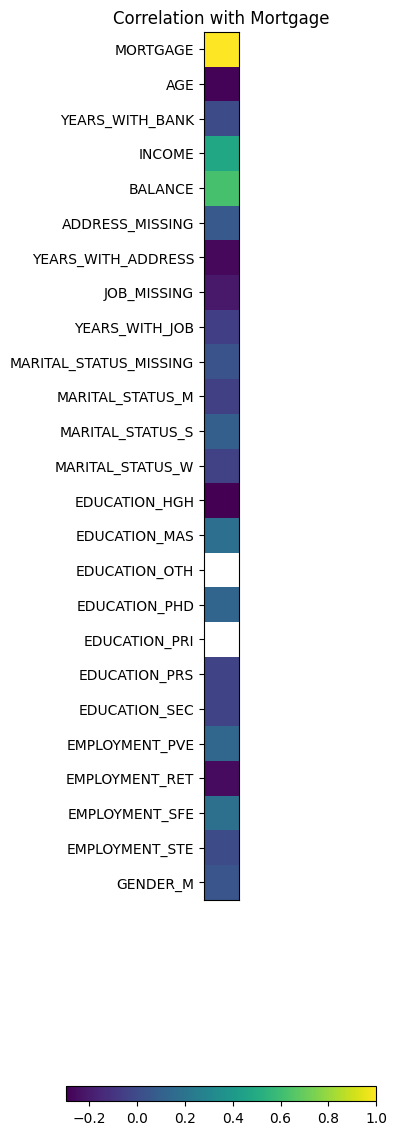

In [27]:
# Select rows with mortgage
mortgage_rows = df["MORTGAGE"] == 1.0

# Select 1000 random rows without mortgage
no_mortgage_rows = df[~mortgage_rows].sample(n=1000, random_state=42)

# Concatenate the rows to a new dataframe
df = pd.concat([df[mortgage_rows], no_mortgage_rows])

# Create a correlation matrix
corr_matrix = df.corr()

# Visualize only the first column of the correlation matrix
plt.matshow(corr_matrix.iloc[:, :1])
plt.xticks([])
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.colorbar(orientation="horizontal")
plt.title("Correlation with Mortgage")
plt.show()